In [3]:
#All the imports
import json
import csv
from pprint import pprint
import math
import matplotlib.pyplot as plt
from math import log as ln
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7.5)
init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


/Users/varungoel/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
plot = True
data_dir = '../data/'
datafile = data_dir + 'data.json'

In [5]:
#gets the distribution of births (by month) for a particular year and plots it
def get_year_distribution(datafile, year):
	year = str(year)
	with open(datafile) as f:
		data = json.load(f)
		data_year = data[year]

		if plot:
			births = {month:0 for month in data_year}
			for month in data_year:
				month_births = 0
				month_data = data_year[month]
				for date in month_data:
					month_births += month_data[date]['births']
				births[month] = month_births
			
			births = {int(month): births[month]/100000 for month in births}
			lists = sorted(births.items()) # sorted by key, return a list of tuples
			x, y = zip(*lists) # unpack a list of pairs into two tuples
			plt.plot(x, y,marker='o')
			plt.xlabel('Year')
			plt.ylabel('Births in hundred thousand')
			plt.title('Monthly births in the year ' + str(year))
			plt.ylim([2.5,4])
			plt.show()

		return data_year


#the distribution of births across each month from 1994-2014
def get_combined_monthly_births(datafile):
	births = {str(i):0 for i in range(1, 13)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_births = 0
				month_data = year_data[month]
				for date in month_data:
					month_births += month_data[date]['births']
				births[month] += month_births

	births = {int(month): births[month]/1000000 for month in births}
	lists = sorted(births.items()) # sorted by key, return a list of tuples
	x, y = zip(*lists) # unpack a list of pairs into two tuples
	plt.plot(x, y,marker='o')
	plt.xlabel('Month')
	plt.ylabel('Births in million')
	plt.title('Total births in a month across 1994-2014')
	plt.ylim([6,8])
	plt.show()
    
def get_combined_monthly_births(datafile):
	births = {str(i):0 for i in range(1, 13)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_births = 0
				month_data = year_data[month]
				for date in month_data:
					month_births += month_data[date]['births']
				births[month] += month_births

	births = {int(month): births[month]/1000000 for month in births}
	lists = sorted(births.items()) # sorted by key, return a list of tuples
	x, y = zip(*lists) # unpack a list of pairs into two tuples
	plt.plot(x, y,marker='o')
	plt.xlabel('Month')
	plt.ylabel('Births in million')
	plt.title('Total births in a month across 1994-2014')
	plt.ylim([6,8])
	plt.show()

# Births per year

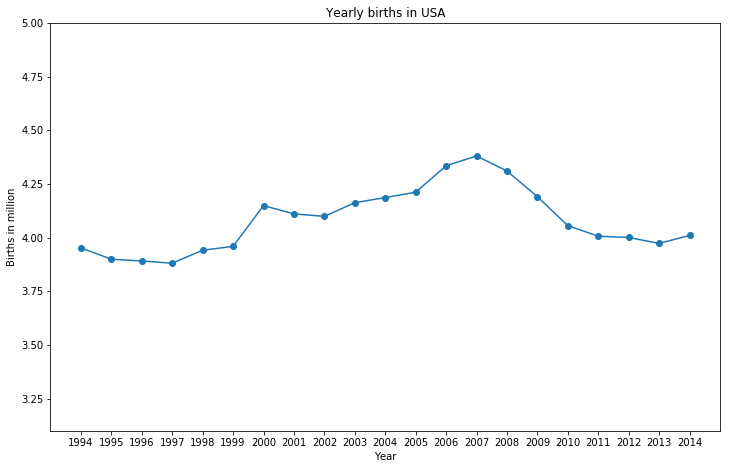

<Figure size 1080x1080 with 0 Axes>

{'1994': 3.952767,
 '1995': 3.899589,
 '1996': 3.891494,
 '1997': 3.880894,
 '1998': 3.941553,
 '1999': 3.959417,
 '2000': 4.149598,
 '2001': 4.110963,
 '2002': 4.099313,
 '2003': 4.16306,
 '2004': 4.186863,
 '2005': 4.211941,
 '2006': 4.335154,
 '2007': 4.380784,
 '2008': 4.310737,
 '2009': 4.190991,
 '2010': 4.055975,
 '2011': 4.006908,
 '2012': 4.000868,
 '2013': 3.973337,
 '2014': 4.010532}

In [99]:
#gets the data for the number of births from 1994-2014 and plots them 
def get_yearly_births(datafile, plot=False):
	births = {str(i):0 for i in range(1994, 2015)}

	with open(datafile) as f:
		data = json.load(f)
		
		for year in data:
			year_births = 0
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for day in month_data:
					year_births += int(month_data[day]['births'])

			births[year] = year_births

	if plot:
		sum = 1000000
		births = {year:births[year]/sum for year in births}

		lists = sorted(births.items()) # sorted by key, return a list of tuples
		x, y = zip(*lists) # unpack a list of pairs into two tuples
		plt.plot(x, y,marker='o')
		plt.xlabel('Year')
		plt.ylabel('Births in million')
		plt.title('Yearly births in USA')
		plt.ylim([3.1,5])
		plt.figure(figsize=(15,15))
		plt.show()
	
	return births

get_yearly_births(datafile, plot)

# Comparing births on each day

In [8]:
#get the daily birth info for all years and plot the heatmap
def get_combined_day_births(datafile):
	births = {i:0 for i in range(1, 367)}
	births = {month:{} for month in range(1, 13)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for date in month_data:
					if int(date) not in births[int(month)]:
						births[int(month)][int(date)] = 0
					births[int(month)][int(date)] += month_data[date]['births']

	months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
	date_list = [x for x in range(1, 32)]

	z = []
	i = 0

	rank_list = []

	for month in births:
		i += 1
		month_data = births[i]
		new_row = []
		for date in date_list:
			if date in month_data:
				new_row.append(month_data[date])
				rank_list.append(month_data[date])
			else:
				new_row.append(0)
				rank_list.append(0)
		z.append(new_row)

	#z[1][28] *= 4
	rank_list.sort()
	rank_list = rank_list[::-1]

	hovertext = list()
	for month in months:
		hovertext.append(list())
		month_data = z[months.index(month)]
		for date_val in date_list:
			birth_count = month_data[int(date_val) - 1]
			to_append = 'Month: ' + str(month) + '<br />Date: ' + str(date_val) + '<br />Births: ' + str(birth_count) + '<br />Rank: ' + str(rank_list.index(birth_count) + 1)
			hovertext[-1].append(to_append)

	data = [
	go.Heatmap(
		z=z,
		x=date_list,
		y=months,
		colorscale='Jet',
		hoverinfo='text',
		text=hovertext
		)
	]

	layout = go.Layout(
		title='Births per date from 1994-2014',
		xaxis = dict(ticks='', nticks=31),
		yaxis = dict(ticks='' )
	)

	fig = go.Figure(data=data, layout=layout)
	iplot(fig,show_link=False)# filename='datetime-heatmap')

In [7]:
get_combined_day_births(datafile)

# Which days are more popular

In [33]:
def get_day_distribution(datafile):
	days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
	births = {i : 0 for i in range(1, 8)}
	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_births = 0
				month_data = year_data[month]
				for date in month_data:
					day = month_data[date]['day']
					births[int(day)] += month_data[date]['births']
		
		births = {days[i - 1] : births[i] for i in range(1, 8)}
		pprint(births)
		total = 1000000
		births = {day:(births[day]/total) for day in births}

		plt.xlabel('Day')
		plt.ylabel('Number of births (in millions)')
		plt.ylim([0,15])
		plt.title('Number of births by day in USA from 1994-2014')
		plt.bar(list(births.keys()), births.values())
		plt.show()

{'Friday': 13522413,
 'Monday': 12720974,
 'Saturday': 9449669,
 'Sunday': 8368365,
 'Thursday': 13744222,
 'Tuesday': 14074616,
 'Wednesday': 13832479}


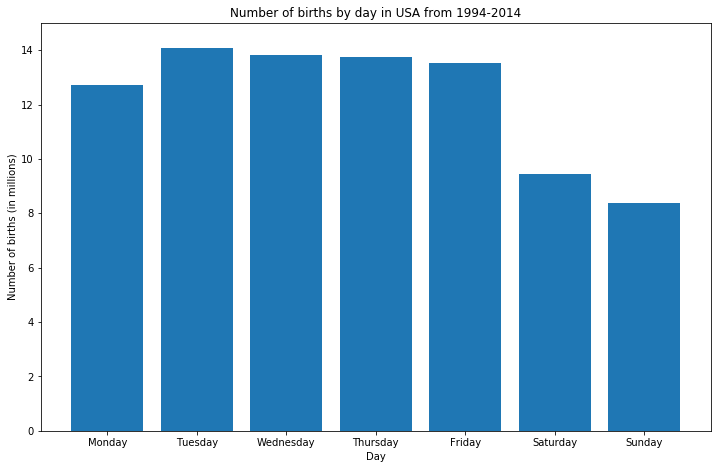

In [34]:
get_day_distribution(datafile)

# How ominous is the 13th 

In [40]:
def friday_thirteen_special(datafile, val1 = 6, val2 = 20):
	days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
	#store info about births on date val1. Each key is the day that the 13th was
	prev = {i : 0 for i in range(1, 8)}
	#info about 13th
	thirteenth = {i : 0 for i in range(1, 8)}
	#info about date val2
	next_ = {i : 0 for i in range(1, 8)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for date in month_data:
					#only considering the 13th of every month
					day = month_data['13']['day']
					if int(date) == val1 or int(date) == 13 or int(date) == val2:
						date_data = month_data[date]
						births = month_data[date]['births']
						if int(date) == val1:
							prev[int(day)] += births
						elif int(date) == 13:
							thirteenth[int(day)] += births
						elif int(date) == val2:
							next_[int(day)] += births

	avgs = [((prev[i] + next_[i])/2) - thirteenth[i] for i in range(1, 8)]
	avgs_dict = {days[i]:-avgs[i]/1000 for i in range(0, 7)}
	pprint(avgs_dict)
	plt.ylabel('Difference (in thousand)')
	plt.title('Difference in the number of births on 13th and average number of births on 6th and 20th across all months')
	plt.xlabel('Day')
	plt.bar(list(avgs_dict.keys()), avgs_dict.values())
    
	fig_size = plt.rcParams["figure.figsize"]
 
	fig_size[0] = 12
	fig_size[1] = 7.5
	plt.rcParams["figure.figsize"] = fig_size

	plt.ylim([-30,0])
	plt.show()

{'Friday': -28.0245,
 'Monday': -7.9325,
 'Saturday': -2.0895,
 'Sunday': -2.8425,
 'Thursday': -16.1505,
 'Tuesday': -9.736,
 'Wednesday': -12.915}


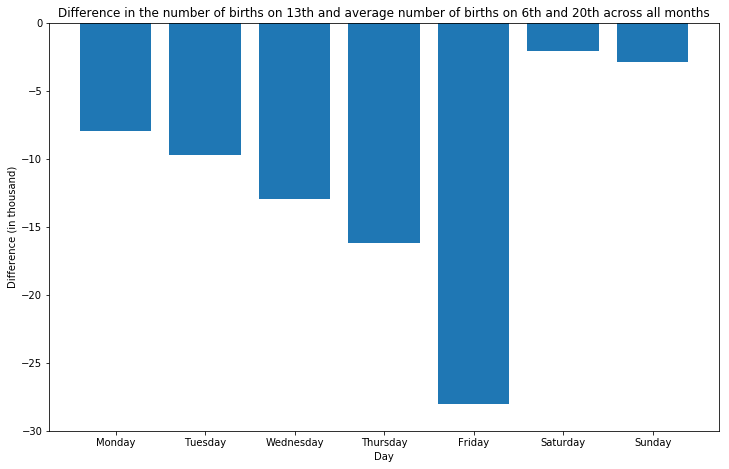

In [41]:
friday_thirteen_special(datafile)